In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import numpy as np
import matplotlib.pyplot as plt

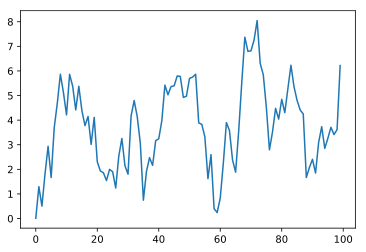

In [3]:
plt.plot(np.random.standard_normal(100).cumsum())
plt.show()